<a href="https://colab.research.google.com/github/whorseman/Assignments/blob/main/learningportfolio_Gluonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
from google.colab import drive
from google.colab import data_table
import matplotlib.pyplot as plt
data_table.enable_dataframe_formatter()

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install -q gluonts==0.12.*

In [ ]:
data  = pd.read_csv("/content/drive/MyDrive/DIGO/BTC-USD-2.csv",index_col='Date', parse_dates=True)
data['item_id'] = 'BTC'

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,item_id
Date,,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004,BTC
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547,BTC
2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362,BTC
2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219,45897.574219,42494677905,BTC
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859,BTC


In [ ]:
#transform pandas dataframe into gluonts dataset with target variable defined as opening price and item_id as BTC (only needed when using multiple time series)
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(data, target="Open", item_id='item_id')

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
#defining several helper functions visualize train/test split
from gluonts.dataset.util import to_pandas


def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

In [ ]:
from gluonts.dataset.split import split

prediction_length = 30
training_dataset, test_template = split(
    ds, date=pd.Period("2022-11-01 00:00:00", freq="1D")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=2,
)

plot_dataset_splitting(ds, training_dataset, test_pairs)

In [ ]:
!pip install -q "gluonts[mxnet]"

In [40]:
from gluonts.mx import DeepAREstimator, Trainer

estimator = DeepAREstimator(
    freq=ds.freq, prediction_length=30, trainer=Trainer(epochs=1)
)
predictor = estimator.train(training_dataset)

100%|██████████| 50/50 [00:10<00:00,  4.89it/s, epoch=1/1, avg_epoch_loss=10]


In [98]:
predictions = predictor.predict(training_dataset)
predictions_2 = predictor.predict(test_pairs)

In [101]:
test_entry = next(iter(test_pairs))

In [ ]:
test_entry

The predict function of forecast objects returns a generator object in GluonTS. A generator is an iterable object used to save memory. To do so an iteration is stopped at a certain point and returned with the next() function

In [127]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_entry,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [128]:
#turning the generator object returned by .predict into a list so that the resulting forecast object can be used for plotting and error metrics
import numpy as np
forecasts = list(forecast_it)
tss = list(ts_it)



In [129]:
# first entry of the time series list
ts_entry = tss[0]

#first entry of the test series
dataset_test_entry = test_entry


# first entry of the forecast list
forecast_entry = forecasts[0]

In [133]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

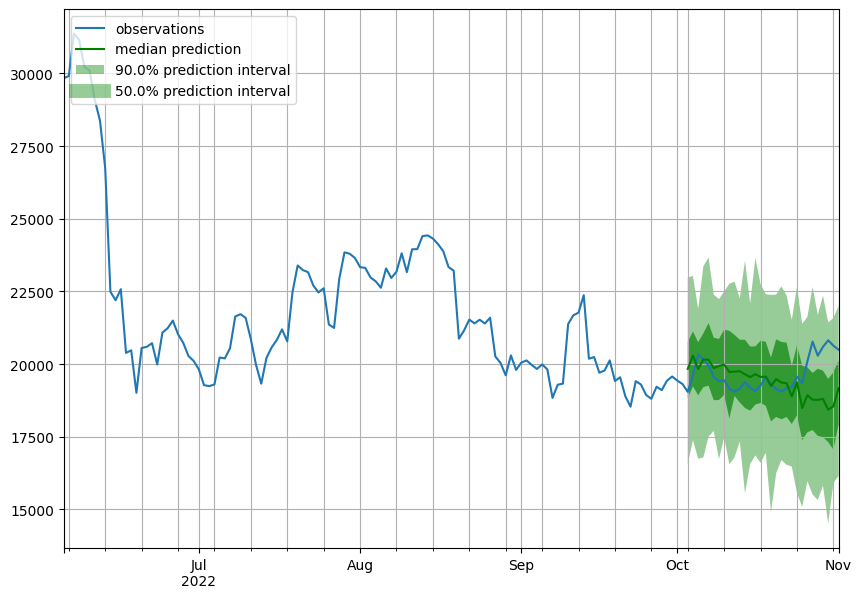

In [134]:
plot_prob_forecasts(ts_entry, forecast_entry)

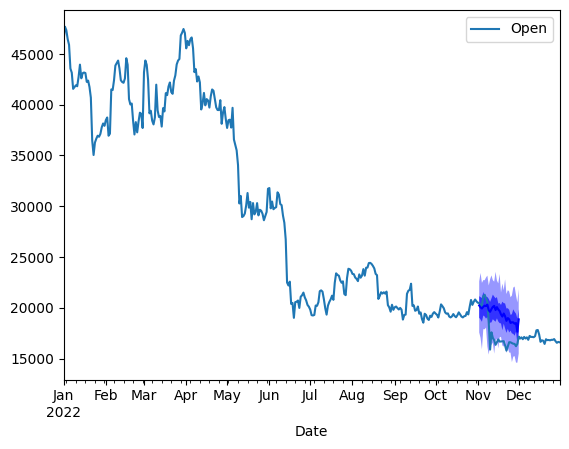

In [107]:
preds = list(predictions)
data.plot(y='Open')
preds[0].plot()
plt.show()